

 <div class="alert alert-block alert-info">

 <b>
 Este proyecto usa **BERT**
 </b> <a class="tocSkip"></a>

 </div>


 <div class="alert alert-block alert-info">

 <b>
Primero que nada, quiero agradecerte Revisor por el tiempo que invertiras revisando este proyecto y por los comentarios que llegues a dejar.

 Sin duda ha sido de los proyectos que mas temas a la vez han tocado y me siento contento de entregar su primera iteración. Aceptare con gusto toda retroalimentación, comentarios y perspectivas para mejorarlo.

Gracias de antemano

    - Omar Mancilla M.
 </b> <a class="tocSkip"></a>

 </div>




# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. 
Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import uniform

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from scipy.stats import randint


from tqdm.auto import notebook_tqdm,tqdm
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
import time

import torch
import transformers

c:\anaconda3\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time = time.time()

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.style.use('seaborn-v0_8-colorblind')

In [4]:
tqdm.pandas()

## Cargar datos
Cargaremos los datos y revisaremos la información general del dataframe:

In [5]:
df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
24160,tt0093624,movie,Night of the Demons,Night of the Demons,1988,\N,90,0,"Comedy,Fantasy,Horror",6.2,12976,"It's the old, old story : kids have a party in...",7,pos,1,test,11451
22104,tt0756689,movie,Mexican Werewolf in Texas,Mexican Werewolf in Texas,2005,\N,88,0,Horror,2.9,584,Mexican Werewolf in Texas is set in the small ...,2,neg,0,test,2549
12131,tt0404030,movie,Everything Is Illuminated,Everything Is Illuminated,2005,\N,106,0,"Comedy,Drama",7.4,56124,This movie was one if not the best movie I've ...,10,pos,1,test,2258
12377,tt0182576,tvSeries,Family Guy,Family Guy,1999,\N,22,0,"Animation,Comedy",8.1,296907,If Family Guy offends you or you simply don't ...,10,pos,1,test,9679
16584,tt0089280,movie,Hobgoblins,Hobgoblins,1988,\N,88,0,"Comedy,Horror,Sci-Fi",2.3,10320,How Rick Sloane was allowed to make five movie...,1,neg,0,train,3098
1514,tt0384793,movie,Accepted,Accepted,2006,\N,93,0,Comedy,6.4,120890,From the creators of Bruce Almighty and Liar L...,9,pos,1,test,3972
24065,tt0119780,movie,"Niagara, Niagara","Niagara, Niagara",1997,\N,93,0,"Drama,Romance",7.1,1505,This movie is truly worth seeing - Robin Tunne...,10,pos,1,test,11021
46474,tt0066845,movie,Will to Die,Blood Legacy,1971,\N,82,0,"Horror,Mystery,Thriller",2.8,665,"I happen to have bought one of those ""Legacy o...",2,neg,0,train,12070
34640,tt0090713,movie,The Best of Times,The Best of Times,1986,\N,104,0,"Comedy,Drama,Sport",6.0,6422,The film did not do well at the box office. I ...,7,pos,1,train,11756
15973,tt0024092,movie,Havana Widows,Havana Widows,1933,\N,62,0,Comedy,6.3,441,Blondell & Farrell are excellent. Blondell was...,10,pos,1,test,2361


Podemos ver los campos del dataframe:

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente
- Multiples columnas sobre información del filme.

Para nuestro modelo los demas campos son innecesarios, eventualmente los retiraremos del DF, sin embargo los usaremos para el EDA.

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

notamos que:
- end_year, runtime_minutes tiene un tipo de valor incorrecto.
- votes tiene datos nulos.

Trataremos estas dos observaciones. Debido a que tenemos pocos datos nulos en algunas categorias y un dataset de gran tamaño, podemos presindir de estas entradas, por otro lado, no retiraremos los valores vacios de "end_year", los reemplazaremos por "0".

In [7]:
df_reviews.dropna(inplace=True)


In [8]:
df_reviews["end_year"]=df_reviews["end_year"].replace("\\N", np.nan).astype(float)
df_reviews["runtime_minutes"] = df_reviews["runtime_minutes"].replace("\\N", np.nan).astype(float)

In [9]:
df_reviews.describe()

,start_year,end_year,runtime_minutes,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,2279.000000,46843.000000,47329.000000,47329.000000,47329.0,47329.000000,47329.000000,47329.000000
mean,1989.630882,1999.539710,98.759729,0.001733,5.998278,25562.917323,5.484439,0.498933,6279.826808
std,19.600702,11.846141,38.322569,0.041588,1.494289,83670.039163,3.473083,0.500004,3605.724280
min,1894.000000,1953.000000,1.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,1995.000000,87.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,2004.000000,95.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6300.000000
75%,2004.000000,2008.000000,109.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,2020.000000,1140.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


Revisamos el desbalance de clases:

pos
0    23715
1    23614
Name: count, dtype: int64


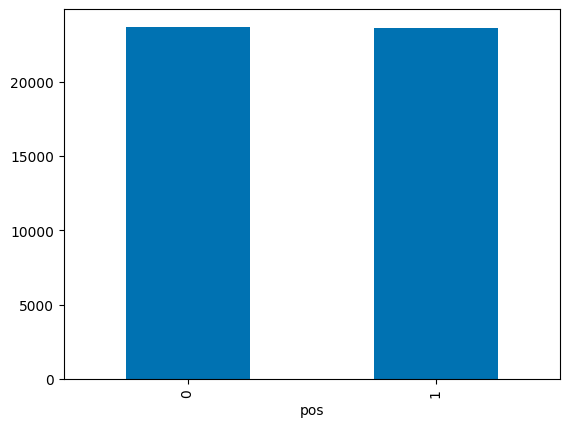

In [10]:
df_reviews['pos'].value_counts().plot(kind='bar')
print(df_reviews['pos'].value_counts())


Vemos que esta relativamente equilibrado, esto se explora mas en el EDA.

## EDA

### Peliculas y reseñas por año:
Veamos el número de películas y reseñas a lo largo de los años.

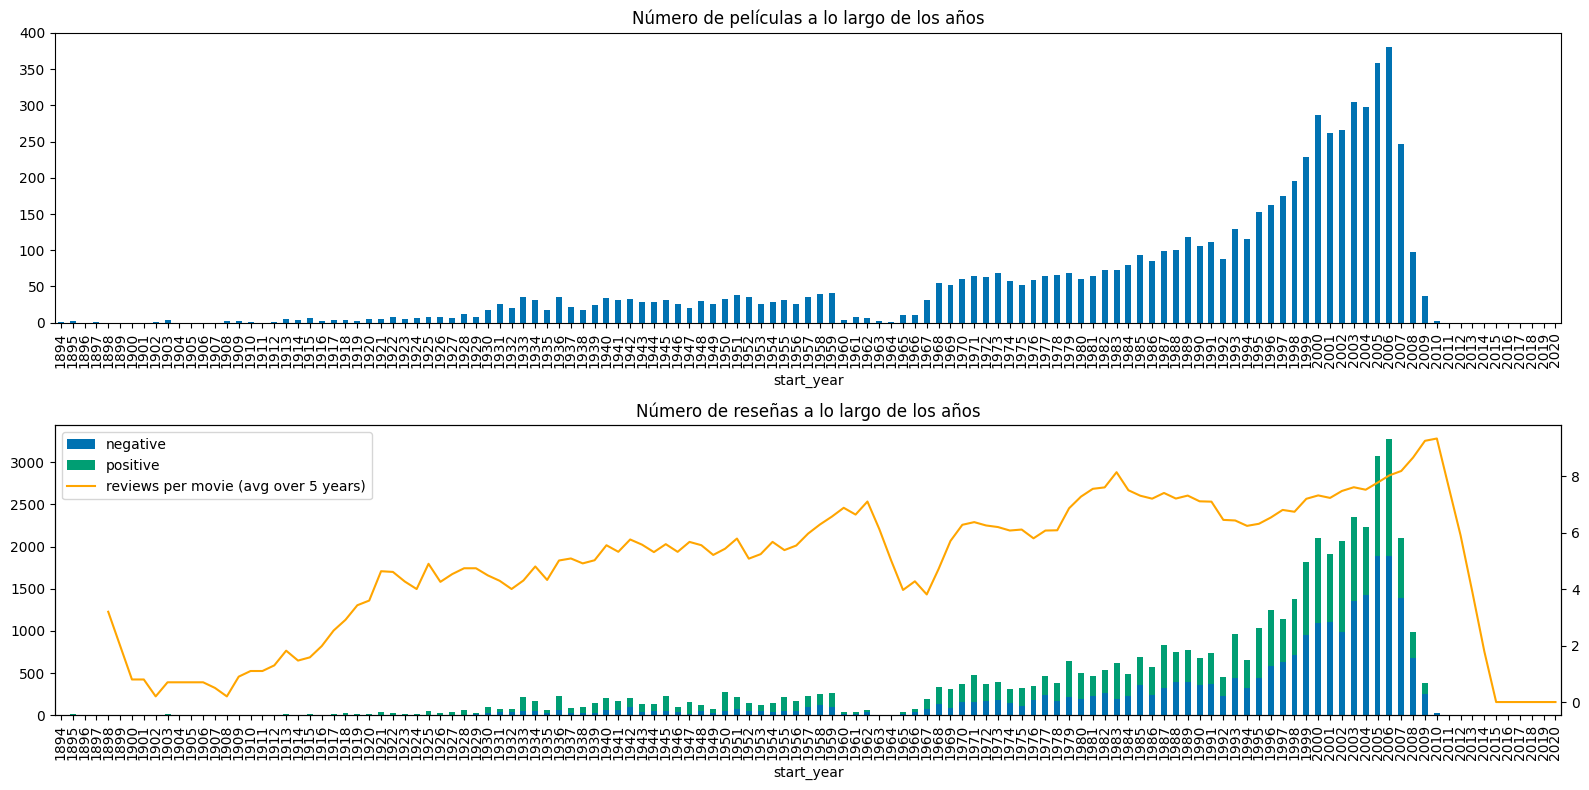

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2 = dft2.rename(columns={0: 'negative', 1: 'positive'})
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft_ratio =  dft2['positive']/(dft2['positive'] +dft2['negative'])*100 #Preparamos un DF auxiliar para el tercer grafico


dft2.plot(kind='bar', stacked=True, label='# reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)


lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axt, labels_axt = axt.get_legend_handles_labels()

ax.legend(lines_ax + lines_axt, labels_ax + labels_axt, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

De estos graficos podemos obtener varias observaciones:
- La cantidad de peliculas ha aumentado en las ultimas decadas 
- La cantaidad promedio de reseñas por pelicula ha aumentado sutilmente.
- La relación de reseñas ha disminuido en las ultimas decadas de forma sutil.


### Reseñas por pelicula:
Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

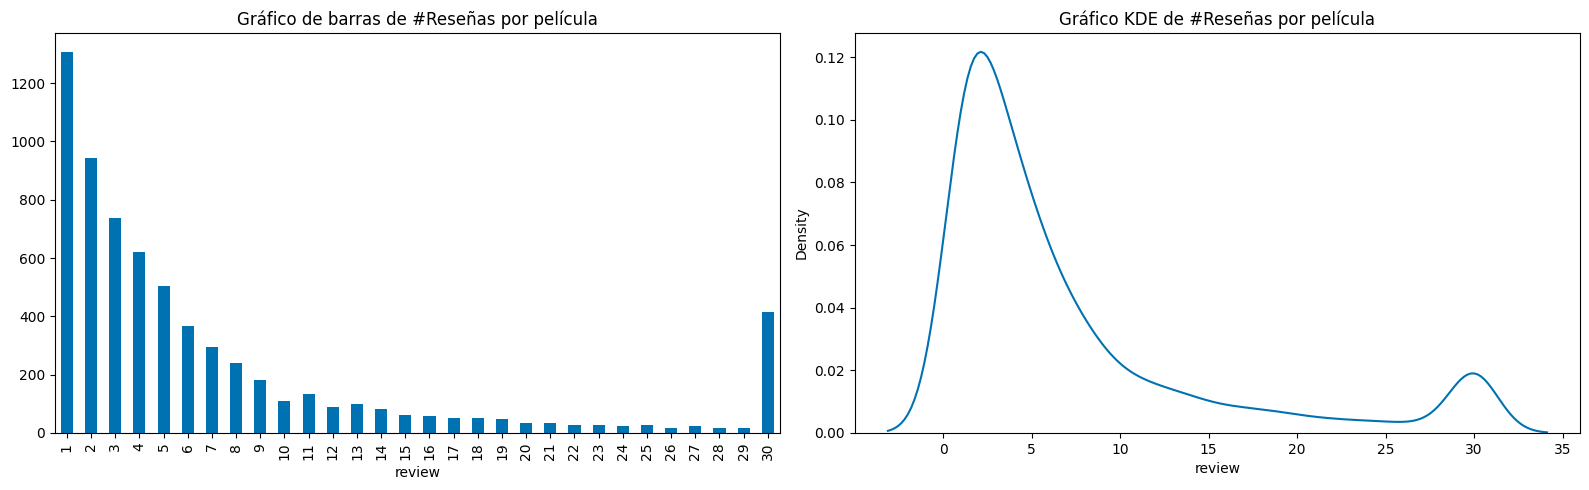

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

### Distribución de clases:
Revisamos la distribución de clases promedio e historicamente:

C:\Users\un-ma\AppData\Local\Temp\ipykernel_21880\1458286738.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


ds_part  pos
test     0      0.501551
         1      0.498449
train    0      0.500588
         1      0.499412
Name: proportion, dtype: float64


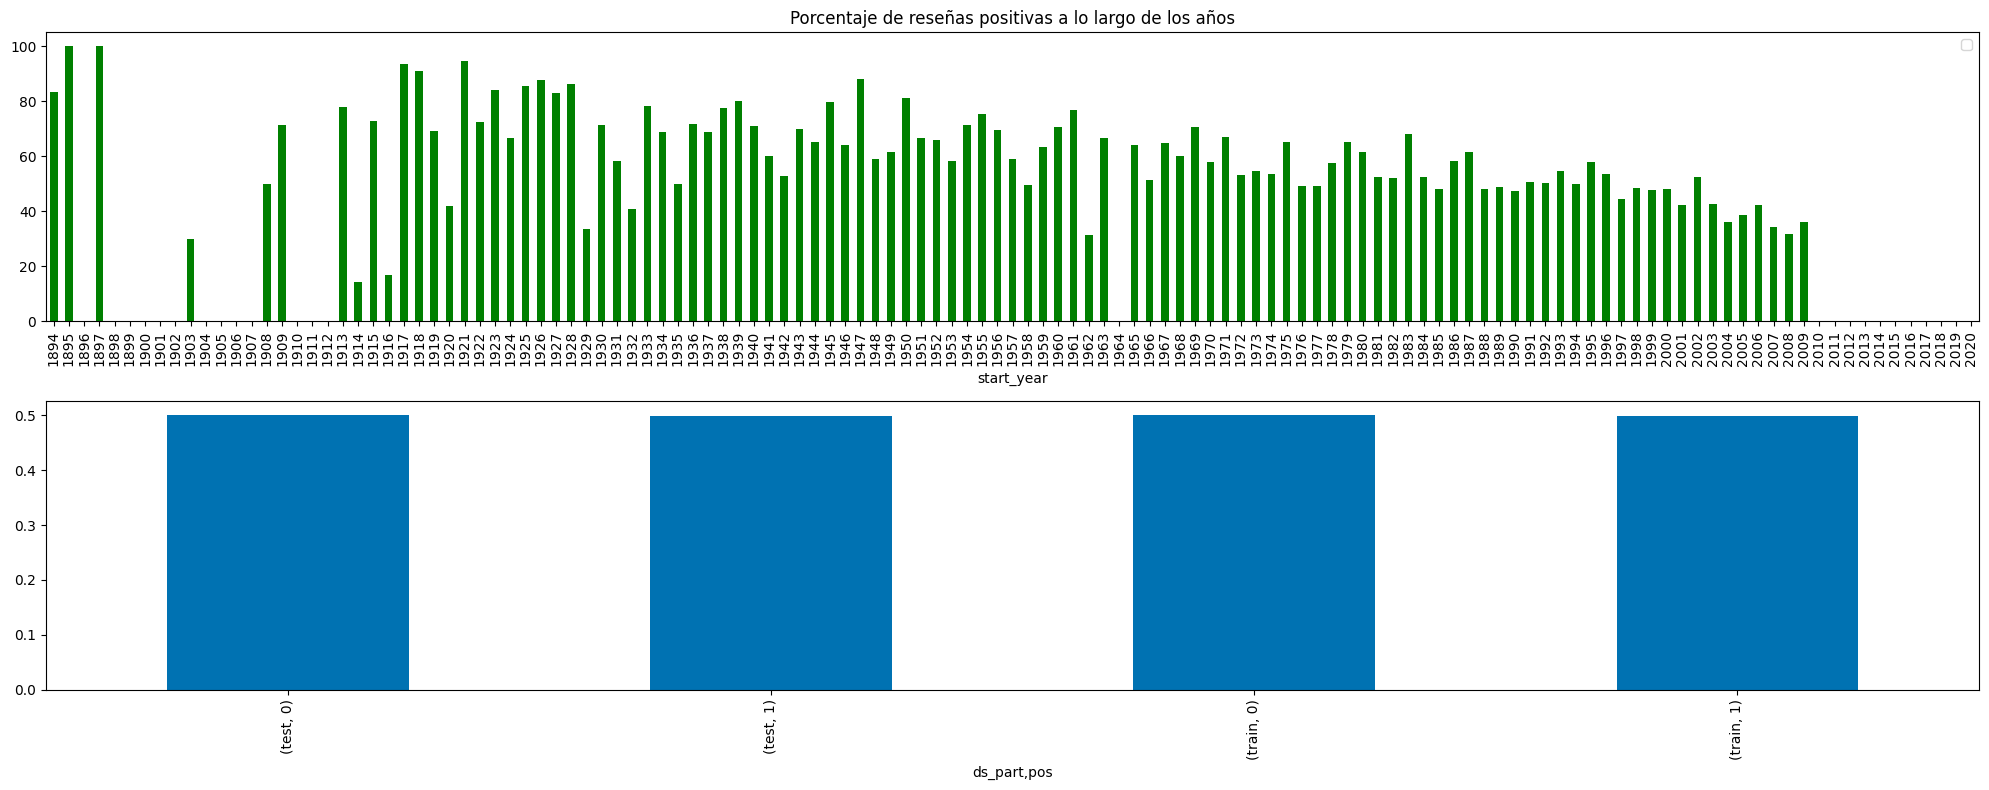

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8))

ax = axs[0]
#dft_ratio = dft2['positive'] / dft2['negative']
dft_ratio = dft_ratio.replace([np.inf, -np.inf], np.nan).fillna(0)  # Manejar división por cero

dft_ratio.plot(kind='bar', color='green', ax=ax)

ax.set_title('Porcentaje de reseñas positivas a lo largo de los años')
ax.legend()
ax = axs[1]

df_reviews.groupby(["ds_part"])["pos"].value_counts(normalize=True).plot(kind='bar')
print(df_reviews.groupby(["ds_part"])["pos"].value_counts(normalize=True))
fig.tight_layout()

Asi podemos ver que historicamente las reseñas han sido relativamente homogeneas, pero mas importante, que nuestros datasets de entrenamiento y prueba estan balanceados.

Aunando mas en esto, revisamos la distribución de puntuaciones en nuestros sets:

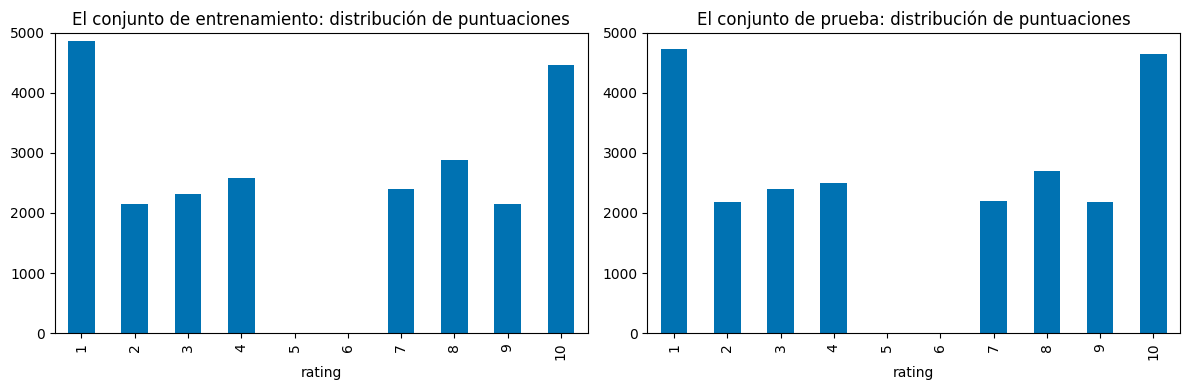

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Con esto podemos determinar que los conjuntos de entrenamiento y prueba estan bien polarizados, lo cual puede hacer que los modelos tengan problemas con nuevas reseñas ambiguas.

### Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\un-ma\AppData\Local\Temp\ipykernel_21880\1821821459.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\un-ma\AppData\Local\Temp\ipykernel_21880\1821821459.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\un-ma\AppData\Local\Temp\ipykernel_21880\1821821459.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\un-ma\AppData\Local\Temp\ipykernel_21880\1821821459.py:31: UserWarning: 

Support for a

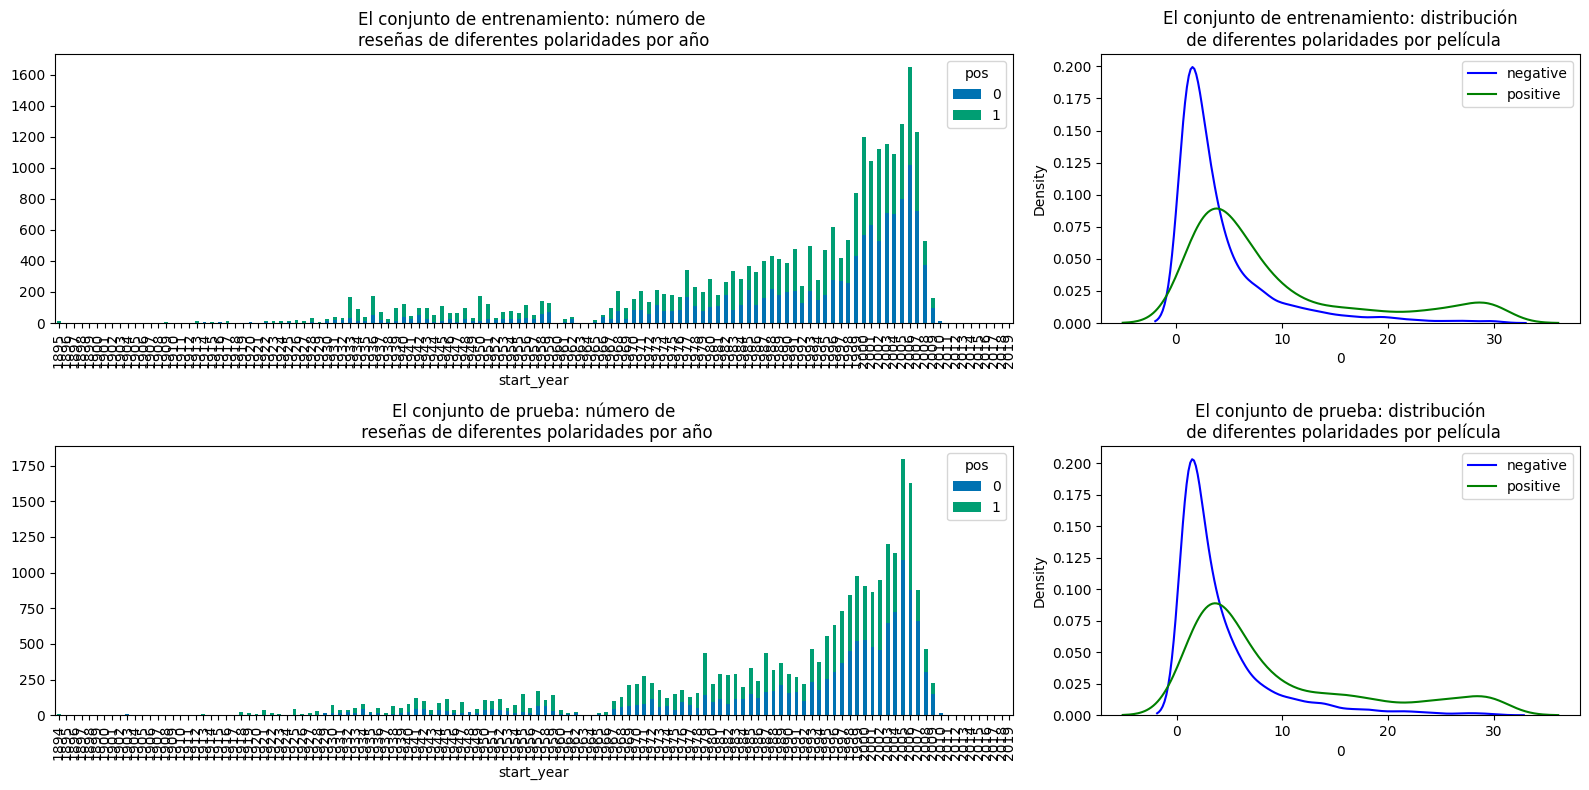

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de \nreseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución\n de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de\n reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución\n de diferentes polaridades por película')

fig.tight_layout()

Observaciones:
- Notamos que la distribución y densidad de reseñas negativas y positivas es similar para ambos conjuntos de datos-
- Tambien notamos que para ambos conjuntos de datos, muy pocas peliculas con reseñas negativas llegan a tener mas de 25 reseñas.


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto.
Esta función devuelve la información de la evaluación para su posterior analisis.

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        #print("eval_stats_Accuaracy:",eval_stats[type]['Accuracy'])
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    #df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    display(df_eval_stats)
    
    return df_eval_stats

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

Creamos funciones que realicen esto con Spacy y NLTK, luego las aplicaremos para generar los vectores.

In [17]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
                 #disable=['parser', 'ner'])

In [18]:
def limpia_texto_spacy(text):
    text = re.sub(r'[^\w\s]|\d+', '', text.lower())

    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    
    return " ".join(lemmas)

In [19]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def limpia_texto_NLTK(text):
    text = re.sub(r'[^\w\s]|[\d+]', '', text.lower())

    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return " ".join(lemmas)


In [20]:
df_reviews['review_norm_spacy'] = df_reviews['review'].progress_apply(limpia_texto_spacy)

100%|██████████| 47329/47329 [07:43<00:00, 102.19it/s]


In [21]:
df_reviews['review_norm_NLTK'] = df_reviews['review'].progress_apply(limpia_texto_NLTK)

100%|██████████| 47329/47329 [00:48<00:00, 978.46it/s] 


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

Tambien retiraemos las caracteristicas innecesarias para los modelos, dejando practicamente solo las reseñas normalizadas.

Primero para los conjuntos de datos de prueba y de prueba procesados con NLTK

In [22]:
train_features = pd.DataFrame(df_reviews.query('ds_part == "train"')["review_norm_NLTK"].copy())
test_features = pd.DataFrame(df_reviews.query('ds_part == "test"')["review_norm_NLTK"].copy())

train_target = pd.DataFrame(df_reviews.query('ds_part == "train"')['pos'])
test_target = pd.DataFrame(df_reviews.query('ds_part == "test"')['pos'])



In [23]:
display(train_features.head())
display(test_features.head())

,review_norm_NLTK
0,pakage implies warren beatty goldie hawn pulli...
1,hell get made presenting caper comedy misbegot...
7,true story carlsons raider army training film ...
8,titled balderdash little film true except name...
9,movie gung ho story carlsons makin island raid...


,review_norm_NLTK
2,real story film seems like fly wall dramadocum...
3,um serious film troubled teen singapore countr...
4,im totally agree garryjohal singapore comment ...
5,first movie ive seen singapore great dont know...
6,yes nonsingaporeans cant see whats big deal fi...


Ahora para aquellos procesados con spaCy

In [24]:
train_features =train_features.join(df_reviews.query('ds_part == "train"')["review_norm_spacy"],on=train_features.index)


In [25]:
test_features = test_features.join(df_reviews.query('ds_part == "test"')["review_norm_spacy"],on=test_features.index)


In [26]:
display(train_features.head())
display(test_features.head())


,key_0,review_norm_NLTK,review_norm_spacy
0,0,pakage implies warren beatty goldie hawn pulli...,pakage imply warren beatty goldie hawn pull hu...
1,1,hell get made presenting caper comedy misbegot...,hell present caper comedy misbegotten essent...
7,7,true story carlsons raider army training film ...,true story carlson raider army training film e...
8,8,titled balderdash little film true except name...,title balderdash little film true island fact ...
9,9,movie gung ho story carlsons makin island raid...,movie gung ho story carlson makin island raide...


,key_0,review_norm_NLTK,review_norm_spacy
2,2,real story film seems like fly wall dramadocum...,real story film like fly wall dramadocumentary...
3,3,um serious film troubled teen singapore countr...,um film troubled teen singapore country know...
4,4,im totally agree garryjohal singapore comment ...,m totally agree garryjohal singapore comment f...
5,5,first movie ive seen singapore great dont know...,movie ve see singapore great not know lot asia...
6,6,yes nonsingaporeans cant see whats big deal fi...,yes nonsingaporean not s big deal film referen...


Y los conjuntos de objetivos:

In [27]:
display(train_target.value_counts())
display(test_target.value_counts())

pos
0      11912
1      11884
Name: count, dtype: int64

pos
0      11803
1      11730
Name: count, dtype: int64

# Observaciones:
Hasta ahora:
- Se han cargado librerias y datos.
- Se han limpiado los datos y corregido tipos de datos.
- Se hizo un analisis exploratorio.
- Se verifico el balance de clases:
    - en todo el dataset.
    - en los sets de entrenamiento y prueba.
- Se definió un procedimiento de evaluación de modelos.
- Se normalizó el texto con SpaCy y NLTK.
- Se hizo la división de datos en un set de entrenamiento y uno de prueba.

# Trabajar con modelos

Aplicaremos un total de once tecnicas de ML learning a los datos y evaluaremos los resultados para cada una de ellos; cada tecnica consta de una  combinación distinta de preprocesamiento, vectorización y modelo de ML.

| Pre-Procesamiento | Vectorización  | Modelo de ML                       |
|-------------------|----------------|------------------------------------|
| -                 | -              | Dummy                              |
| NLTK              | TF-IDF         | Regresión logística                |
| NLTK              | TF-IDF         | Potenciación de gradiente (LightGBM)|
| Spacy             | TF-IDF         | Regresión logística                 |
| Spacy             | TF-IDF         | Potenciación de gradiente (LightGBM)|
| NLTK              | TF-IDF         | Bosque aleatorio                    |
| Spacy             | TF-IDF         | Bosque aleatorio                   |
| NLTK              | Word2Vec| Potenciación de gradiente (LightGBM)|
| Spacy             | Word2Vec| Potenciación de gradiente (LightGBM)|
| NLTK              | BERT           | Potenciación de gradiente (LightGBM)|
| NLTK              | BERT           | Regresión logística                 |


## Modelo 0 - Constante
Creamos un modelo DummyClassifier que asigne de forma estratificada:

In [28]:
dummy_clf = DummyClassifier(strategy="stratified")


Entremaos el modelo dummy con los datos de en train y evaluamos con los datos de test:

In [29]:
dummy_clf.fit(train_features["review_norm_NLTK"], train_target)

DummyClassifier(strategy='stratified')

,train,test
ROC AUC,0.498,0.501
APS,0.499,0.499
Accuracy,0.504,0.500
F1,0.505,0.500


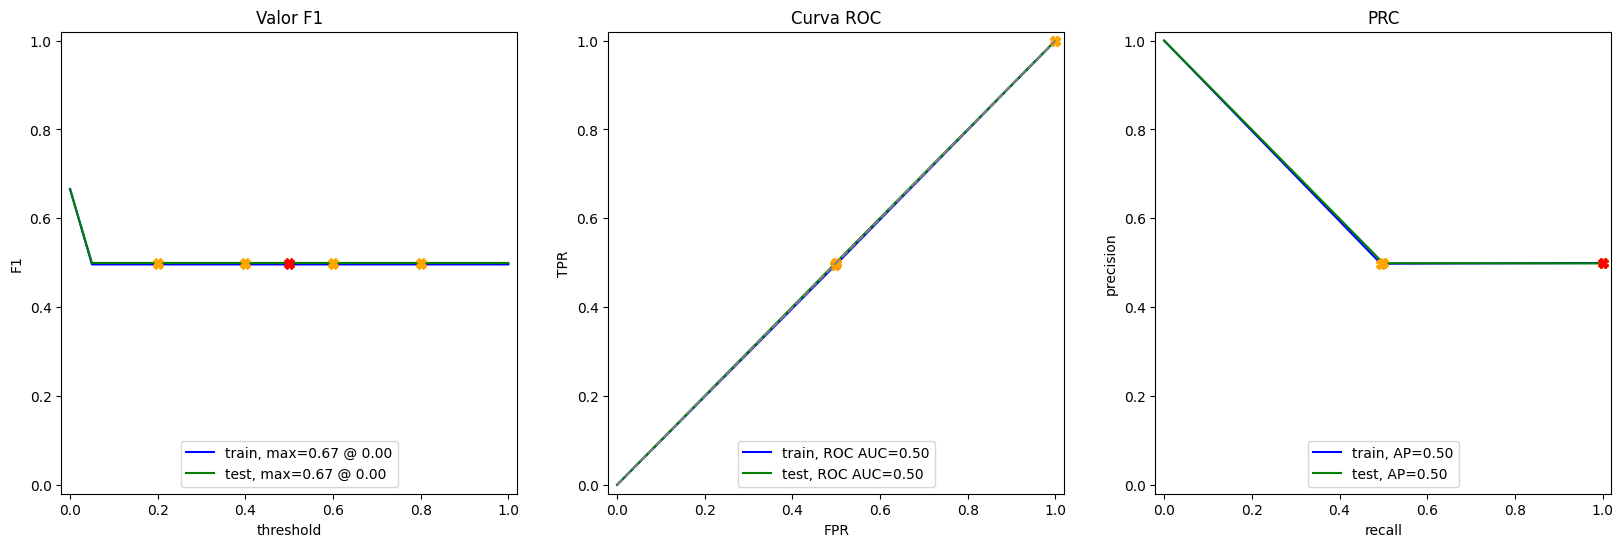

In [30]:
eval_0=evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)

Este modelo no cumple la meta de F1>0.85, pues es dummy y solo sirve como prueba de cordura para los demas.

## Modelo 1 - NLTK, TF-IDF y LR
Usaremos NLTK, TfidfVectorizer y LogisticRegression.


Creamos un vectorizador TF-IDF, luego extraemos las caracteristicas del texto lematizado con NLTK.

Estas caracteristicas seran usadas por modelos posteriores.

In [31]:
count_tf_idf_1 = TfidfVectorizer(stop_words="english")

train_features_1 = count_tf_idf_1.fit_transform(train_features["review_norm_NLTK"])
test_features_1 = count_tf_idf_1.transform(test_features["review_norm_NLTK"])
#features_1= count_tf_idf_1.transform(pd.concat([train_features["review_norm_NLTK"],test_features["review_norm_NLTK"]]))


In [32]:
print('El tamaño de la matriz TF-IDF:', train_features_1.shape)

El tamaño de la matriz TF-IDF: (23796, 96960)


Tras revisar el tamaño de nuestras caracteristicas, creamos un modelo de regresión logística y lo entenamos con las caracteristicas:

In [33]:
model_1 = LogisticRegression(solver='liblinear')
model_1.fit(train_features_1, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='liblinear')

Evaluamos el modelo con los datos de test:

,train,test
ROC AUC,0.982,0.947
APS,0.982,0.945
Accuracy,0.936,0.876
F1,0.936,0.875


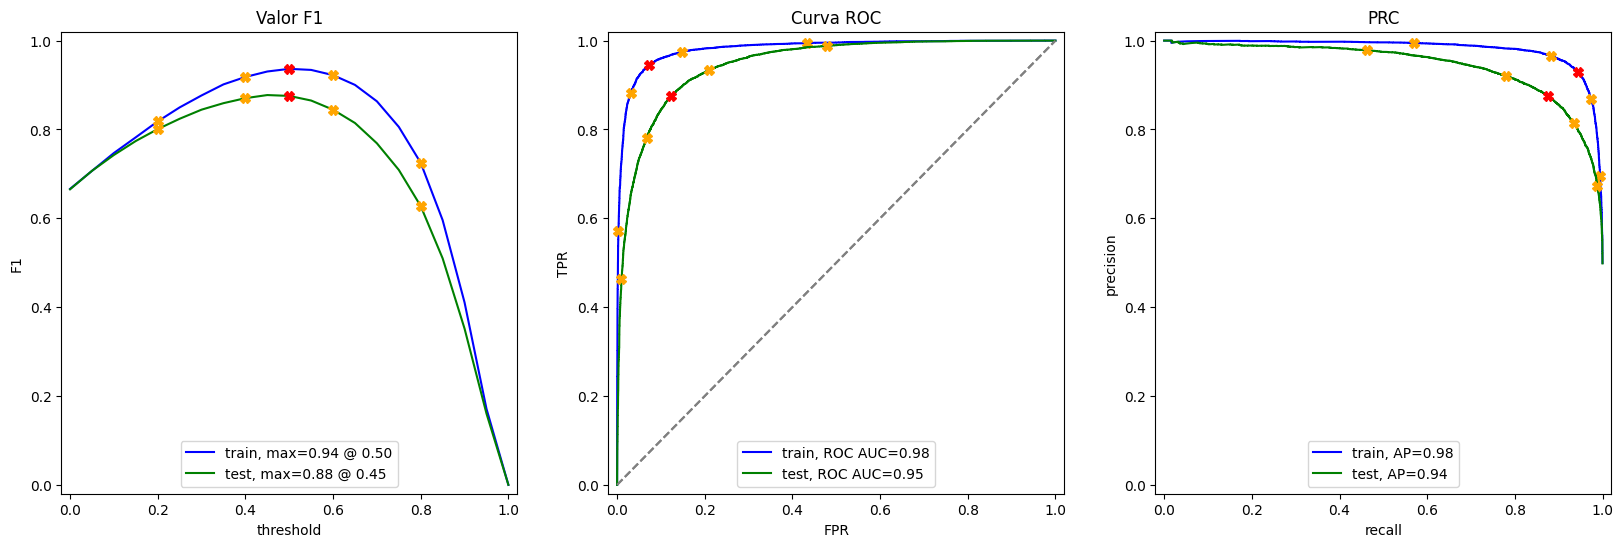

In [34]:
eval_1=evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Este modelo tiene un rendimineto **aceptable** con una metrica F1 de 0.875 en el set de prueba.

## Modelo 2 - NLTK, TF-IDF y LGBMClassifier

Como ahora usaremos potenciación del gradiente, haremos una busqueda aleatorea de hiperparametros al entrenar el clasificador.

Primero, definimos la distibución de parametros:

In [35]:
param_dist  = {
    'n_estimators': randint(50, 250),
    'learning_rate': uniform(loc=0.01, scale=0.29), 
    'max_depth' : randint(2,9)}

Ahora aplicamos la busqueda de hiperparametros con una busqueda aleatoria y cross validation con 4 folds, buscando optimizar el valor F1.

In [36]:
model_2 = LGBMClassifier()

random_search = RandomizedSearchCV (estimator=model_2, param_distributions=param_dist, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_1,train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.695757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452786
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 10225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020810FDBC10>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FDBB80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002087A3CCFD0>},
                   scoring='f1')

Mostramos los mejores hiperparametros y entrenamos un modelo con ellos:

In [37]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("----------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n----------------------------")
model_2_best = LGBMClassifier(**best_params)
model_2_best.fit(train_features_1,train_target)


----------------------------
Mejores hiperparámetros: {'learning_rate': 0.266460295857826, 'max_depth': 7, 'n_estimators': 167}
Mejor score: 0.8474688170279437 
----------------------------


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452786
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 10225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(learning_rate=0.266460295857826, max_depth=7, n_estimators=167)

Finalmente evaluamos el mejor modelo:

,train,test
ROC AUC,0.995,0.932
APS,0.995,0.930
Accuracy,0.964,0.856
F1,0.964,0.857


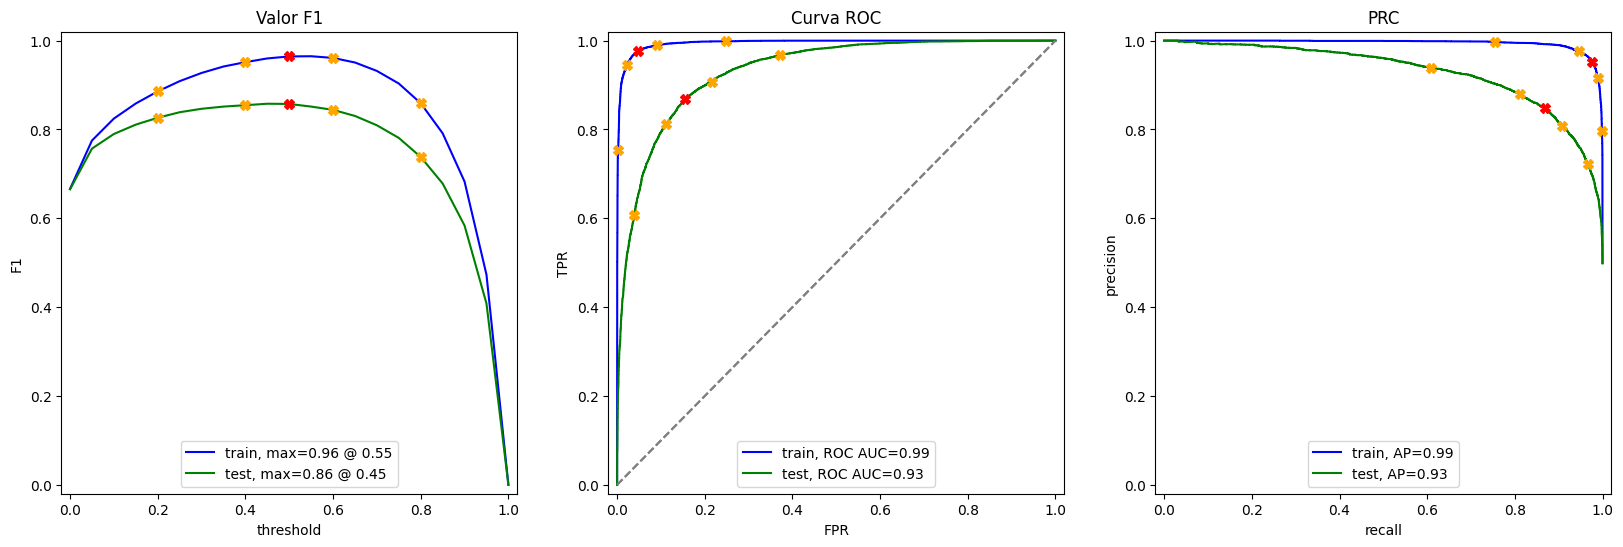

In [38]:
eval_2=evaluate_model(model_2_best, train_features_1, train_target, test_features_1, test_target)

Este modelo tiene un rendimineto **aceptable** con una metrica F1 de 0.868 en el set de prueba.

## Modelo 3 - spaCy, TF-IDF y LR

Usaremos spaCy, TfidfVectorizer y LogisticRegression con una metodologia similar al modelo 1.

Vectorizamos usando las reseñas lematizadas por Spacy.

Estas caracteristicas tambien seran usadas por modelos posteriores.

In [39]:
count_tf_idf_3 = TfidfVectorizer(stop_words="english")

train_features_2 = count_tf_idf_3.fit_transform(train_features["review_norm_spacy"])
test_features_2 = count_tf_idf_3.transform(test_features["review_norm_spacy"])
#features_2= count_tf_idf_3.transform(pd.concat([train_features["review_norm_spacy"],test_features["review_norm_spacy"]]))

Revisamos las caracteristicas, creamos un modelo de regresión logística y lo entenamos con las caracteristicas:

In [40]:
print('El tamaño de la matriz TF-IDF:', train_features_2.shape)

El tamaño de la matriz TF-IDF: (23796, 91250)


In [41]:
model_3 = LogisticRegression(solver='liblinear')
model_3.fit(train_features_2, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='liblinear')

Evaluamos con los datos de prueba y guardamos los resultados de la evaluación:

,train,test
ROC AUC,0.980,0.945
APS,0.980,0.943
Accuracy,0.932,0.874
F1,0.932,0.874


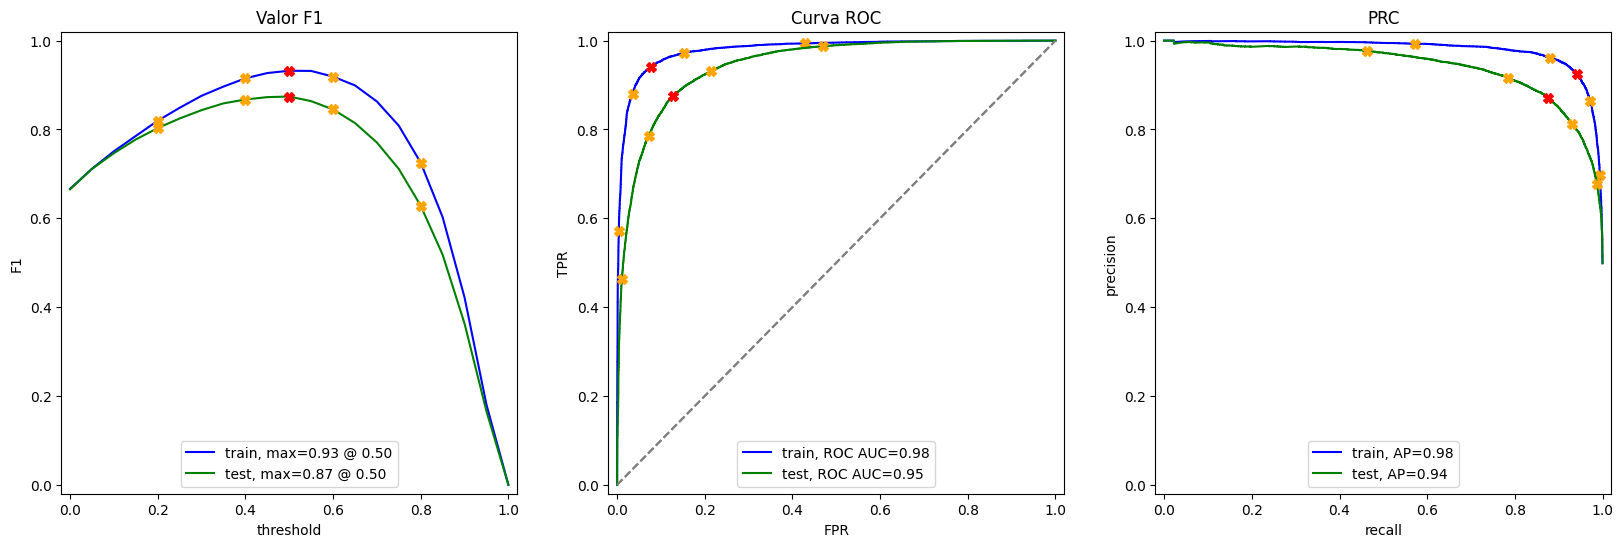

In [42]:
eval_3=evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

Este modelo tiene un rendimineto **aceptable** con una metrica F1 de 0.874 en el set de prueba.

## Modelo 4 - spaCy, TF-IDF y LGBMClassifier
Ahora, de forma similar al modelo 2:
Primero, definimos la distibución de parametros:

In [43]:
param_dist  = {
    'n_estimators': randint(50, 250),
    'learning_rate': uniform(loc=0.01, scale=0.29), 
    'max_depth' : randint(2,9)}

Creamos un modelo y lo entenamos con una busqueda aleatoria y cross validation con 4 folds, buscando optimizar el valor F1.

In [44]:
model_4 = LGBMClassifier()

random_search = RandomizedSearchCV (estimator=model_4, param_distributions=param_dist, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_2,train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415308
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020811196C80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020811196A10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002081553E950>},
                   scoring='f1')

Tras encontrar los mejores hiperparametros, entrenamos un modelo con ellos:

In [45]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("----------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n----------------------------")
model_4_best = LGBMClassifier(**best_params)
model_4_best.fit(train_features_2, train_target)

----------------------------
Mejores hiperparámetros: {'learning_rate': 0.2428589303365436, 'max_depth': 6, 'n_estimators': 204}
Mejor score: 0.848897070549592 
----------------------------


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415308
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(learning_rate=0.2428589303365436, max_depth=6, n_estimators=204)

Finalmente, evaluamos el mejor modelo con los datos de prueba:

,train,test
ROC AUC,0.991,0.932
APS,0.991,0.930
Accuracy,0.954,0.855
F1,0.955,0.856


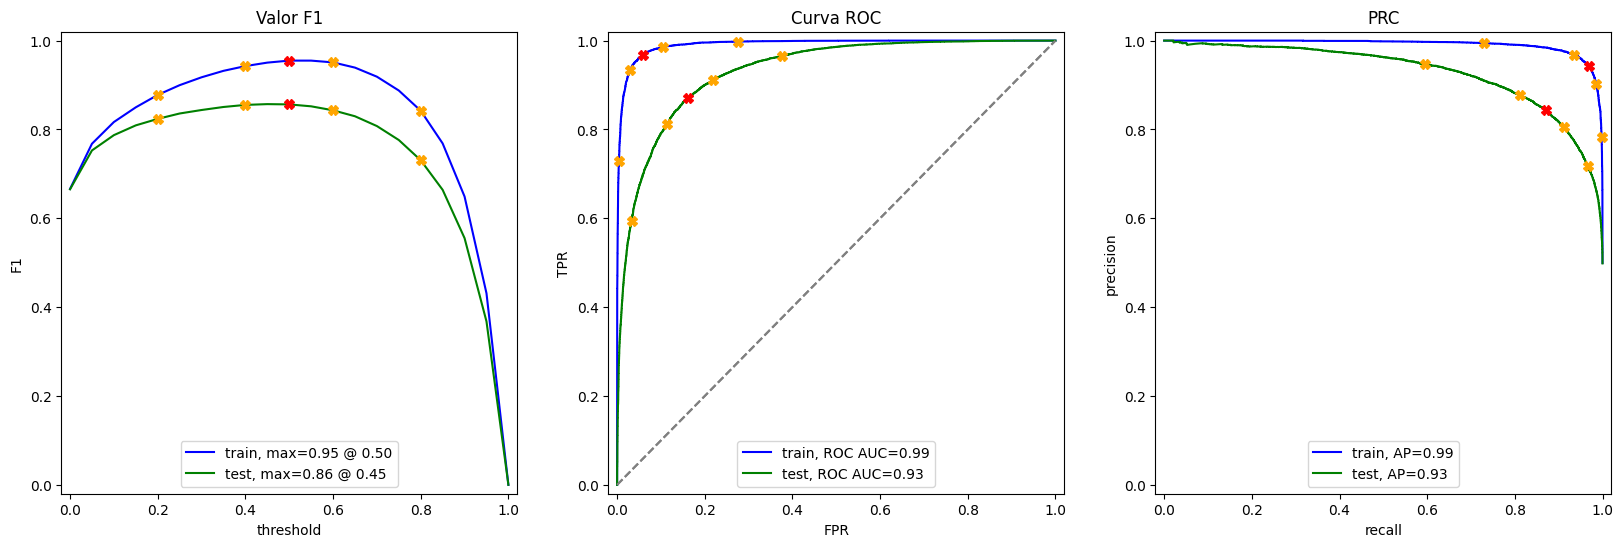

In [46]:
eval_4=evaluate_model(model_4_best, train_features_2, train_target, test_features_2, test_target)

Este modelo tambien es **aceptable** con una metrica F1 de 0.864 en el set de prueba.

## Modelo 5 - NLTK, TF-IDF y random forest
Realizaremos un procedimiento similar a los modelos que usaron potenciación del gradiente.

Primero, definimos la distibución de parametros, esta distribución se usara tambien para el modelo 6:

In [47]:
param_dist = {
    'n_estimators': randint(100, 1000),  
    'max_depth': randint(10, 50), 
    'min_samples_split': randint(2, 11),  
    'min_samples_leaf': randint(1, 5)  
}

Instanciamos un bosque aleatorio, usando las caracteristicas generadas por NLTK y TF-IDF  lo entrenamos con una busqueda aleatoria y cross validation con 4 folds, buscando optimizar el valor F1.

In [48]:
model_5 =RandomForestClassifier()

random_search = RandomizedSearchCV (estimator=model_5, param_distributions=param_dist, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_1, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA0700>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA0D30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA1F00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002081554B700>},
                   scoring='f1')

Tras encontrar los mejores hiperparametros, entrenamos un modelo con estos.

In [49]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("--------------------------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n--------------------------------------------")
model_5_best = RandomForestClassifier(**best_params)
model_5_best.fit(train_features_1, train_target)

--------------------------------------------
Mejores hiperparámetros: {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 684}
Mejor score: 0.8499880831676896 
--------------------------------------------


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=47, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=684)

Finalmente evaluamos el mejor modelo con los datos de prueba y almacenamos los resultados:

,train,test
ROC AUC,0.994,0.929
APS,0.994,0.925
Accuracy,0.958,0.852
F1,0.959,0.853


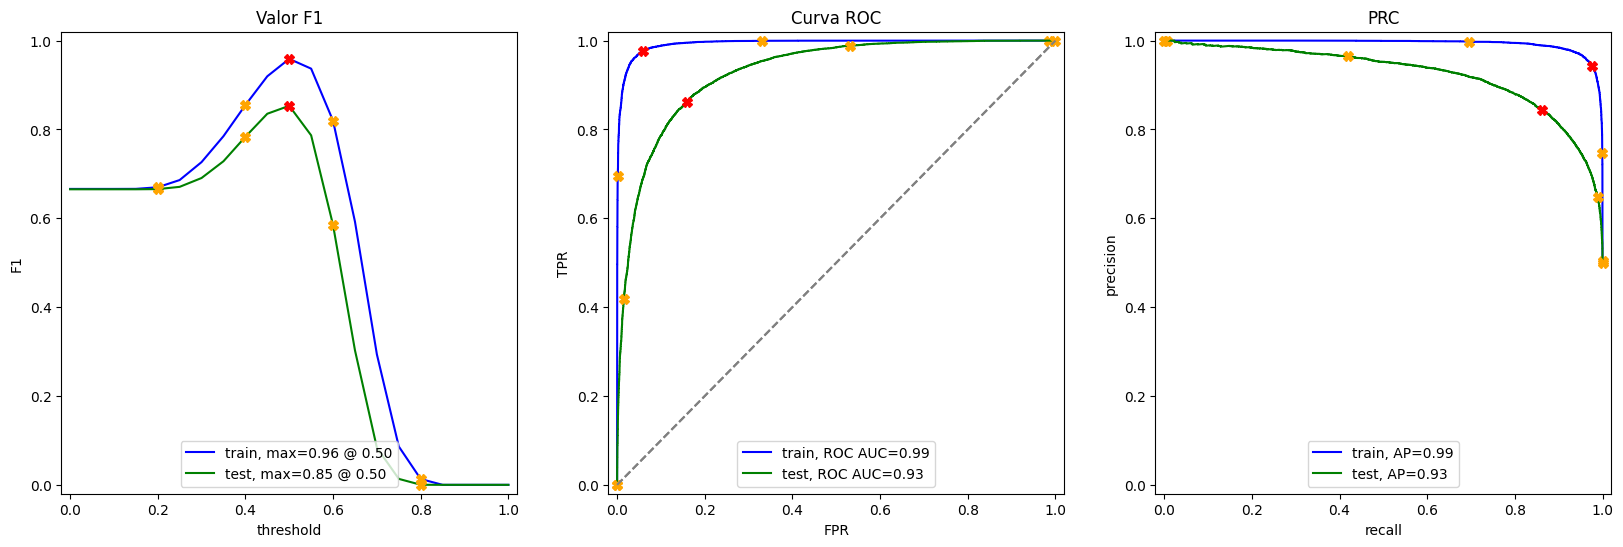

In [50]:
eval_5=evaluate_model(model_5_best, train_features_1, train_target, test_features_1, test_target)

Este modelo es **aceptable** con una metrica F1 de 0.854 en el set de prueba; notamos que este parece estar sobreajustado a los datos de entrenamiento, evidenciado por las curvas ROC y PRC azules.

## Modelo 6 - SpaCy, TF-IDF y random forest
De forma similar al modelo 5, crearemos el modelo 6 usando las caracteristicas generadas con SpaCy y TF-IDF, al igual que la distribución de parametros ya definida para el modelo 5.

Instanciamos un bosque aleatorio y buscamos sus hiperparametros optimos con cross-validations con 4 folds, optimizando para F1.

In [51]:
model_6 =RandomForestClassifier()

random_search = RandomizedSearchCV (estimator=model_5, param_distributions=param_dist, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_2, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA0700>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA0D30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020810FA1F00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002081554B700>},
                   scoring='f1')

Obtenemos los mejores hiperparametros y entrenamos:

In [52]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_)
model_6_best = RandomForestClassifier(**best_params)
model_6_best.fit(train_features_2, train_target)

Mejores hiperparámetros: {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 664}
Mejor score: 0.8489092447874886


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=41, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=664)

Evaluamos el mejor modelo:

,train,test
ROC AUC,0.992,0.929
APS,0.992,0.925
Accuracy,0.952,0.853
F1,0.952,0.854


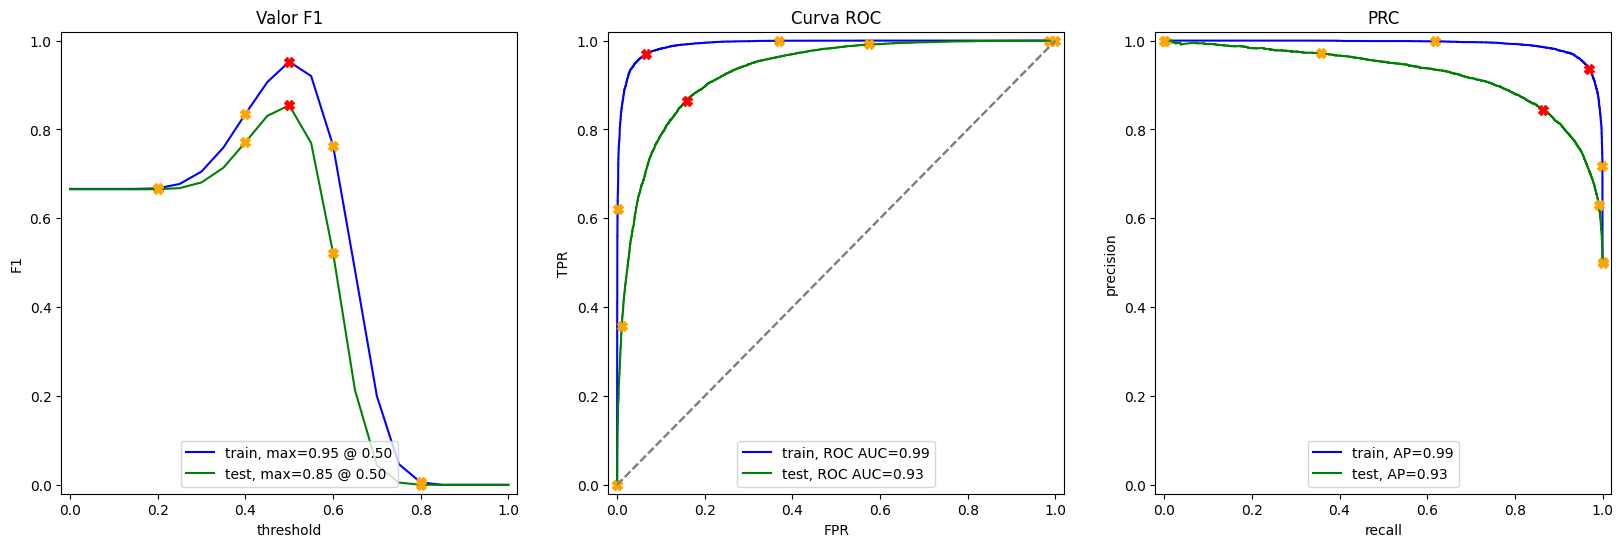

In [53]:
eval_6=evaluate_model(model_6_best, train_features_2, train_target, test_features_2, test_target)

Este modelo tambien es **aceptable** con una metrica F1 de 0.864 en el set de prueba. 

Notamos que este modelo tambien esta sobreajustado al set de entrenamiento, debido a la cercania de la curva azul ROC y PRC, comparada con la del set de prueba.

## Modelo 7 - NLTK, Word2Vec y LightGBM 


### Preprocesamiento del texto:

Para usar Word2Vec, primero debemos entrenar a Word2Vec, en este caso con las reviews procesadas con NLTK.

In [54]:
sentences = [review.split() for review in train_features["review_norm_NLTK"]]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


Requerimos una función para vectorizar el texto y obtener las características, dicha función tambien se usara en el modelo 8.

Definimos la función:


In [55]:
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size) 
    return np.mean(word_vectors, axis=0)


Y la aplicamos para obtener las características de los textos:

In [56]:
train_features_7 = np.array([vectorize_text(text, word2vec_model) for text in train_features["review_norm_NLTK"]])
test_features_7 = np.array([vectorize_text(text, word2vec_model) for text in test_features["review_norm_NLTK"]])


### Modelo de ML con word2vec

Posteriormente podemos aplicar ML usando un modelo de potenciaón de gradiente.

In [57]:
param_dist  = {
    'n_estimators': randint(50, 250),
    'learning_rate': uniform(loc=0.01, scale=0.29),  # uniformamente distribuido entre 0.01 y 0.3
    'max_depth' : randint(2,9)}

In [58]:
model_7 = LGBMClassifier()

random_search = RandomizedSearchCV (estimator=model_7, 
                                    param_distributions=param_dist,
                                    n_iter=20, 
                                    cv= 4, 
                                    n_jobs=-1, 
                                    scoring='f1',
                                    verbose=0)

random_search.fit(train_features_7, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020811C4EB60>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000208119E8DC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000208119D3D00>},
                   scoring='f1')

In [59]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("------------------------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n------------------------------------------")

model_7_best = LGBMClassifier(**best_params) #pasamos el diccionario como parametros con **
model_7_best.fit(train_features_7,train_target)

------------------------------------------
Mejores hiperparámetros: {'learning_rate': 0.0742070700620535, 'max_depth': 7, 'n_estimators': 212}
Mejor score: 0.8334366856133675 
------------------------------------------
[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.0742070700620535, max_depth=7, n_estimators=212)

y evaluar con la función definida:

,train,test
ROC AUC,0.980,0.916
APS,0.981,0.913
Accuracy,0.927,0.833
F1,0.927,0.833


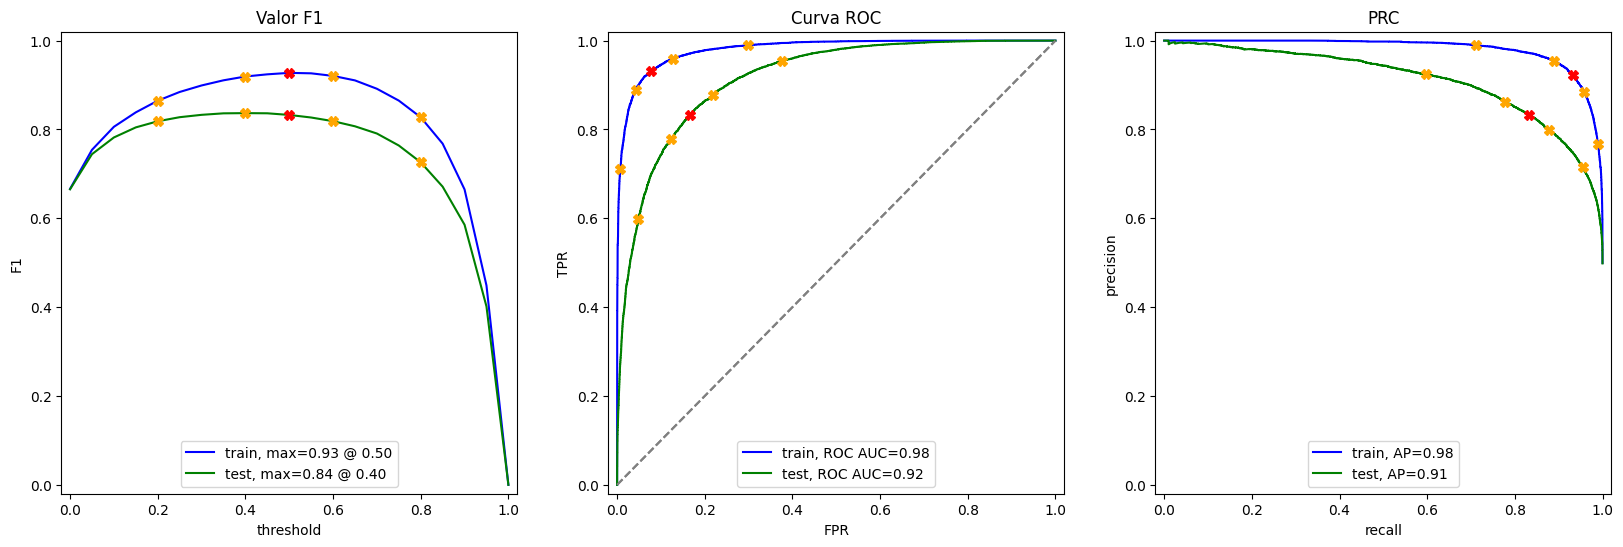

In [60]:
eval_7 = evaluate_model(model_7_best, train_features_7, train_target, test_features_7, test_target)


Notamos que pese a las tecnicas utilizadas, el modelo **no es aceptable**, pues no cumple con la cota de F1>0.85.

## Modelo 8 - spaCy, TF-IDF, LightGBM con word2vec
Haremos algo similar al modelo 7 usando los datos procesados con SpaCy
### Preprocesamiento del texto:

Entrenamos Word2Vec:

In [61]:
sentences = [review.split() for review in train_features["review_norm_spacy"]]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

Aplicamos la función para vectorizar el texto definida en el modelo anterior y obtenemos las características:

In [62]:
train_features_8 = np.array([vectorize_text(text, word2vec_model) for text in train_features["review_norm_spacy"]])
test_features_8 = np.array([vectorize_text(text, word2vec_model) for text in test_features["review_norm_spacy"]])


### Modelo de ML con word2vec:

Instanciamos LightGBM y aplicamos RandomSearchCV, con 4 folds y optimizando para F1.

In [63]:
model_8 = LGBMClassifier()

random_search = RandomizedSearchCV (estimator=model_8, param_distributions=param_dist,n_iter=20, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_8, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020811C4EB60>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000208119E8DC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000208119D3D00>},
                   scoring='f1')

Entrenamos con los mejores hiperparametros:

In [64]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("------------------------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n------------------------------------------")
model_8_best = LGBMClassifier(**best_params)
model_8_best.fit(train_features_8,train_target)

------------------------------------------
Mejores hiperparámetros: {'learning_rate': 0.1438975159180183, 'max_depth': 3, 'n_estimators': 227}
Mejor score: 0.8259915479724578 
------------------------------------------
[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(learning_rate=0.1438975159180183, max_depth=3, n_estimators=227)

Evaluamos el mejor modelo resultante:

,train,test
ROC AUC,0.945,0.908
APS,0.944,0.904
Accuracy,0.871,0.827
F1,0.872,0.827


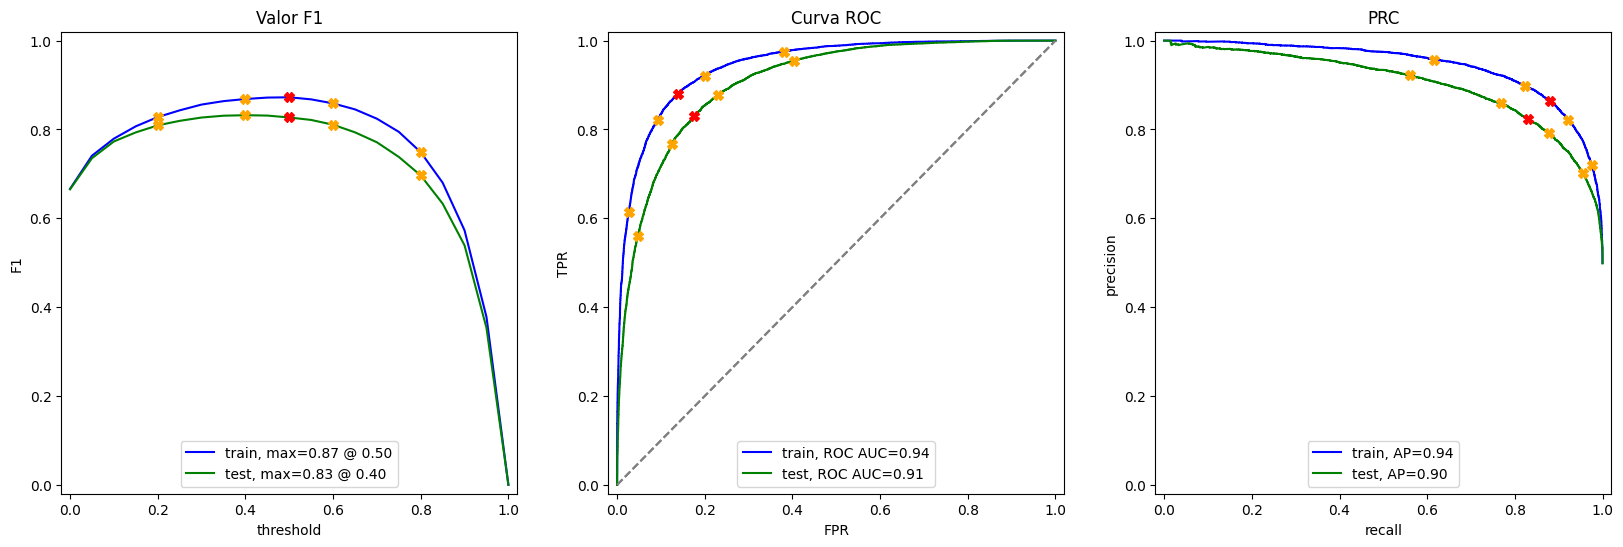

In [65]:
eval_8 = evaluate_model(model_8_best, train_features_8, train_target, test_features_8, test_target)


Vemos que este modelo tampoco es aceptable, pues tampoco cumple la cota de F1>0.85.

##  Modelo 9 - BERT con NLTK y LightGBM
Usaremos BERT para preprocesamiento de texto, debido al tiempo de procesamiento que requiere, solo usaremos el modelo de ML que mejores resultados haya dado:

### Selección de modelo de ML:

Buscaremos entre los modelos anteriores aquellos con mejor puntuaje F1:

In [66]:
evaluations=pd.DataFrame(eval_0)
i=0
for model in [eval_1, eval_2, eval_3, eval_4, eval_5, eval_6, eval_7, eval_8]:  
    i+=1
    evaluations=evaluations.join(model, rsuffix=i)
evaluations=evaluations.transpose()

# Asignar el nuevo índice al DataFrame

evaluations=(evaluations.query("index.str.contains('test')", engine='python')["F1"])
new_index = [f'model_{i }' for i in range(len(evaluations))] 

evaluations.index = pd.MultiIndex.from_arrays([new_index, evaluations.index], names=('Model', 'Set'))
pd.DataFrame(evaluations)

,,F1
Model,Set,
model_0,test,0.500
model_1,test1,0.875
model_2,test2,0.857
model_3,test3,0.874
model_4,test4,0.856
model_5,test5,0.853
model_6,test6,0.854
model_7,test7,0.833
model_8,test8,0.827


Vemos que el uso de LR y LightGBM con NLTK son las combinación con mejores resultados, asi que estas seran usadas con los datos procesados con BERT.
### Preprocesamiento con BERT:

Configuramos el tokenizador y BERT

In [67]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_bert = transformers.BertModel.from_pretrained('bert-base-uncased')

Definimos la siguiente función que convierte texto a insertados.

In [68]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    print("ids y attention lists:")
    for text in tqdm(texts):
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length )
        #ids_list.append(ids)

        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        ids_list.append(padded)

        attention_mask = np.where(padded != 0, 1, 0)
        attention_mask_list.append(attention_mask)

        ids_array = np.array(ids_list)
        attention_mask_array = np.array(attention_mask_list)
         
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model_bert.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_array[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_array[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():            
            model_bert.eval()
            batch_embeddings = model_bert(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

Nos aseguramos de poder procesar computaciones en GPU.

In [69]:
torch.cuda.is_available()

True

Como ya hemos generado los embeddings, los cargamos de nuevo, en caso de que estos no se encuentren disponibles, se volveran a generar:

In [70]:
try:
    with np.load('features_9.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
        #features_9=data["features_9"]
    print("Archivo 'features_9.npz' cargado.")
except (FileNotFoundError, KeyError):
    print("Archivo 'features_9.npz' no encontrado o incompleto. Generando embeddings...")
    #features_9=pd.concat([train_features["review_norm_NLTK"], test_features["review_norm_NLTK"]])
    train_features_9 = BERT_text_to_embeddings(train_features['review_norm_NLTK'], force_device='cuda')
    test_features_9 = BERT_text_to_embeddings(test_features['review_norm_NLTK'], force_device='cuda')
    #features_9 =BERT_text_to_embeddings(features_9, force_device='cuda')
    np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)
    print("Embeddings generados y archivo 'features_9.npz' guardado.")

Archivo 'features_9.npz' cargado.


Revisamos la estructura de los daframes de caracteristicas  resultantes:

Train_Features:

In [71]:
print(train_features['review_norm_NLTK'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796, 1)


test_features:

In [72]:
print(test_features['review_norm_NLTK'].shape)
print(test_features_9.shape)
print(test_target.shape)

(23533,)
(23533, 768)
(23533, 1)


### BERT con NLTK y LGBMClassifier

Posteriormente podemos aplicar ML usando un modelo de potenciaón de gradiente.

Primero generaremos una distribución de parametros:

In [73]:
param_dist  = {
    'n_estimators': randint(50, 250),
    'learning_rate': uniform(loc=0.01, scale=0.29),  # uniformamente distribuido entre 0.01 y 0.3
    'max_depth' : randint(2,9)}

Intanciaremos el modelo de clasificación LGBMClassifier y haremos una busqueda aleatoria:

In [74]:
model_9 = LGBMClassifier()


random_search = RandomizedSearchCV (estimator=model_9, param_distributions=param_dist,n_iter=20, cv= 4, n_jobs=-1, scoring='f1',verbose=0)

random_search.fit(train_features_9,train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020819AE1180>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020819AE2A70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020819AE3CA0>},
                   scoring='f1')

Con los mejores hiperparametros entrenaremos un modelo:

In [75]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("-----------------------------------------\nMejores hiperparámetros:", best_params)
print("Mejor score:", random_search.best_score_,"\n-----------------------------------------")
model_9_best = LGBMClassifier(**best_params)
model_9_best.fit(train_features_9,train_target)

-----------------------------------------
Mejores hiperparámetros: {'learning_rate': 0.12917087624491383, 'max_depth': 7, 'n_estimators': 246}
Mejor score: 0.7941135977113674 
-----------------------------------------


c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.12917087624491383, max_depth=7, n_estimators=246)

Evaluaremos el modelo con los datos de prueba:

,train,test
ROC AUC,1.000,0.886
APS,1.000,0.884
Accuracy,0.992,0.803
F1,0.992,0.802


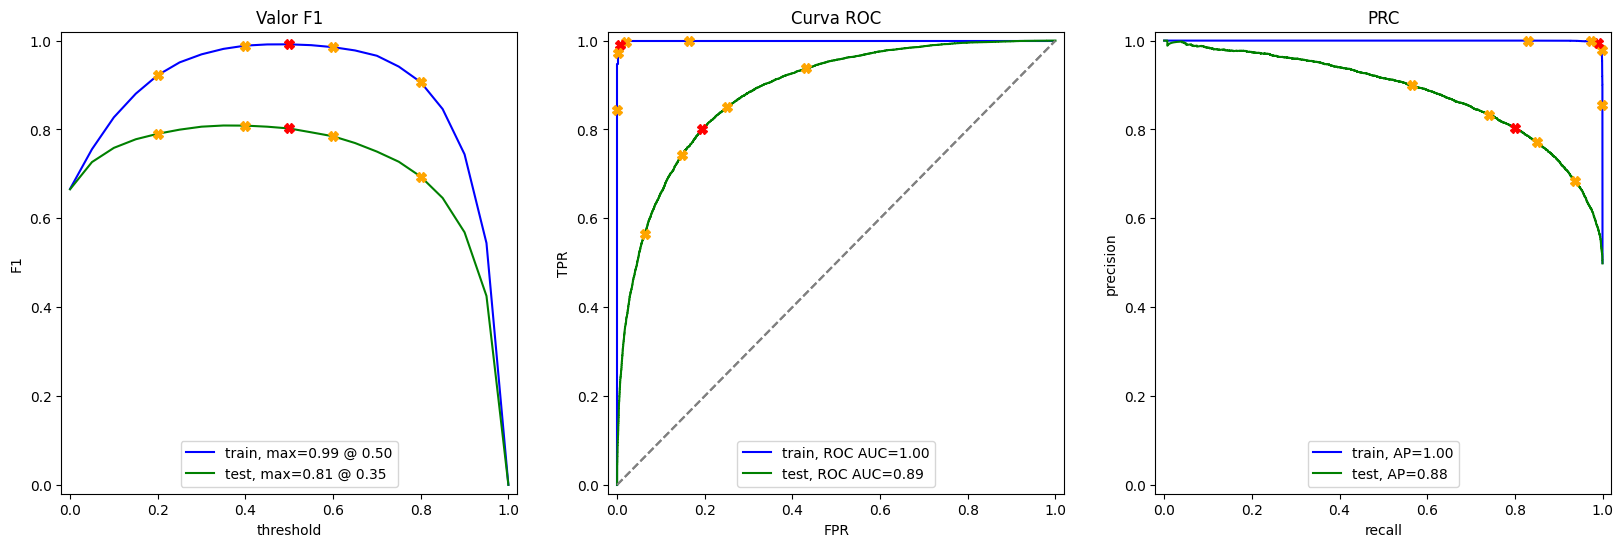

In [76]:
eval_9=evaluate_model(model_9_best, train_features_9, train_target, test_features_9, test_target)

Sorprendentemente, este modelo **no es aceptable**, pues no cumple la cota de F1>0.85.

Este hasta ahora es el resultado mas interesante, pues BERT es el modelo que mas información tiene y aun asi no predice optimamente.

## Modelo 10 - BERT con NLTK y LR

In [77]:
model_10=LogisticRegression(solver='liblinear')

In [78]:
model_10.fit(train_features_9, train_target)

c:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='liblinear')

,train,test
ROC AUC,0.917,0.904
APS,0.916,0.902
Accuracy,0.838,0.826
F1,0.837,0.824


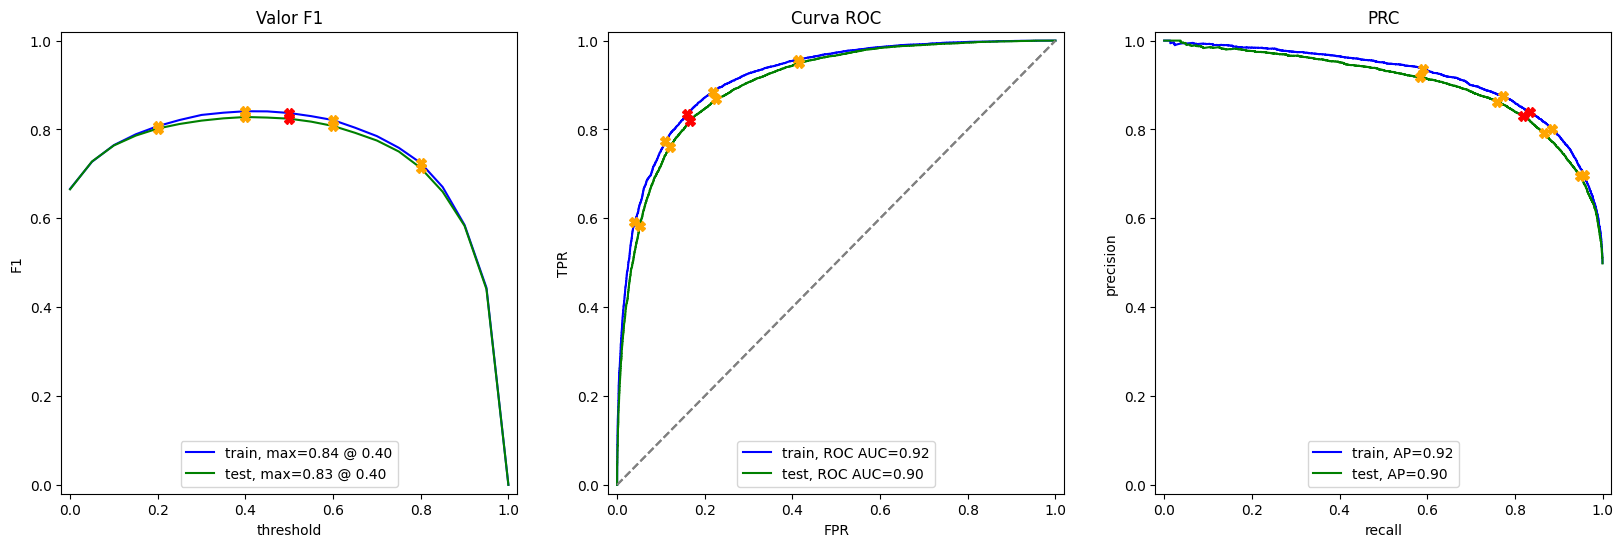

In [79]:
eval_10=evaluate_model(model_10, train_features_9, train_target, test_features_9, test_target)

De forma similar al modelo 9, este modelo **no es aceptable**, por el criterio F1>0.85.


## Evaluación de modelos:
Compararemos las evaluaciones de cada modelo.

In [80]:
evaluations=pd.DataFrame(eval_0)
i=0
for model in [eval_1, eval_2, eval_3, eval_4, eval_5, eval_6, eval_7, eval_8, eval_9,eval_10]:  
    i+=1
    evaluations=evaluations.join(model, rsuffix=i)
evaluations=evaluations.transpose()
new_index = [f'model_{i//2 }' for i in range(len(evaluations))] 

# Asignar el nuevo índice al DataFrame
evaluations.index = pd.MultiIndex.from_arrays([new_index, evaluations.index], names=('Model', 'Set'))
evaluations

ROC AUC    APS  Accuracy     F1
Model    Set                                     
model_0  train      0.498  0.499     0.504  0.505
         test       0.501  0.499     0.500  0.500
model_1  train1     0.982  0.982     0.936  0.936
         test1      0.947  0.945     0.876  0.875
model_2  train2     0.995  0.995     0.964  0.964
         test2      0.932  0.930     0.856  0.857
model_3  train3     0.980  0.980     0.932  0.932
         test3      0.945  0.943     0.874  0.874
model_4  train4     0.991  0.991     0.954  0.955
         test4      0.932  0.930     0.855  0.856
model_5  train5     0.994  0.994     0.958  0.959
         test5      0.929  0.925     0.852  0.853
model_6  train6     0.992  0.992     0.952  0.952
         test6      0.929  0.925     0.853  0.854
model_7  train7     0.980  0.981     0.927  0.927
         test7      0.916  0.913     0.833  0.833
model_8  train8     0.945  0.944     0.871  0.872
         test8      0.908  0.904     0.827  0.827
model_9  train9     1.000  1.000     0.992  0.992
         test9      0.886  0.884     0.803  0.802
model_10 train10    0.917  0.916     0.838  0.837
         test10     0.904  0.902     0.826  0.824

Enfocandonos unicamente en la metrica F1 del set de prueba y ordenando para su analisis:

In [81]:
evaluations=pd.DataFrame(eval_0["test"])
i=0
for model in [eval_1, eval_2, eval_3, eval_4, eval_5, eval_6, eval_7, eval_8, eval_9, eval_10]:  
    i+=1
    evaluations=evaluations.join(model["test"], rsuffix=i)
evaluations=evaluations.transpose()

display(pd.DataFrame(evaluations["F1"]).sort_values("F1", ascending=False))
#pd.DataFrame(evaluations["F1"]).sort_values("F1", ascending=False).plot(kind="bar")

,F1
test1,0.875
test3,0.874
test2,0.857
test4,0.856
test6,0.854
test5,0.853
test7,0.833
test8,0.827
test10,0.824
test9,0.802


### Observaciones y comentarios:

Junto con los pasos de carga, EDA, preprocesamiento, normalización, vectorización, división de datos, se entrenaron once modelos de ML.

|N°| Pre-Procesamiento | Vectorización  | Modelo de ML                       | F1>0.85          |
|-------------------|-------------------|----------------|------------------------------------|-------------------|
|0| -                 | -              | Dummy                              |x
|1| NLTK              | TF-IDF         | Regresión logística                |$\checkmark$ |
|2| NLTK              | TF-IDF         | Potenciación de gradiente (LightGBM)|$\checkmark$ |
|3| Spacy             | TF-IDF         | Regresión logística                 |$\checkmark$ |
|4| Spacy             | TF-IDF         | Potenciación de gradiente (LightGBM)|$\checkmark$ |
|5| NLTK              | TF-IDF         | Bosque aleatorio                    |$\checkmark$ |
|6| Spacy             | TF-IDF         | Bosque aleatorio                   |$\checkmark$ |
|7| NLTK              | Word2Vec| Potenciación de gradiente (LightGBM)|x|
|8| Spacy             | Word2Vec| Potenciación de gradiente (LightGBM)|x|
|9| NLTK              | BERT           | Potenciación de gradiente (LightGBM)|x|
|10| NLTK              | BERT           | Regresión logística                 |x|

Esto nos recuerda que un modelo mas complejo no necesariamente da mejores resultados, un buen pre procesamiento de los datos, con una vectorización relativamente simple y un modelo de regresión logistica da mejores resultados que un modelo de embedings para este caso.

# Mis reseñas

Procederemos a probar los modelos con reseñas particulares, estas seran procesadas por NLTK y SpaCy:

In [82]:
my_reviews = pd.DataFrame([
    "As good as it is in it's action and effects, the story isn't as good as it could be.",
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'Amazingly mediocre movie. I can\'t wait to see it again!',
    'Weird, funny and diferent; im glad there is directors willing to take risks like this!',
    "an amazing adaptation, the action is amazing and the cast make you feel in the movie",
    "i hate how much i love it"
], columns=['review'])

my_reviews['review_norm_spacy'] = my_reviews['review'].progress_apply(limpia_texto_spacy)
my_reviews['review_norm_NLTK'] = my_reviews['review'].progress_apply(limpia_texto_NLTK)

Models_predictions=pd.DataFrame(my_reviews.drop(['review_norm_spacy',"review_norm_NLTK"],axis=1).copy())

my_reviews

100%|██████████| 13/13 [00:00<00:00, 6503.57it/s]


,review,review_norm_spacy,review_norm_NLTK
0,"As good as it is in it's action and effects, t...",good action effect story not good,good action effect story isnt good could
1,"I did not simply like it, not my kind of movie.",simply like kind movie,simply like kind movie
2,"Well, I was bored and felt asleep in the middl...",bored feel asleep middle movie,well bored felt asleep middle movie
3,I was really fascinated with the movie,fascinated movie,really fascinated movie
4,Even the actors looked really old and disinter...,actor look old disintereste get pay movie soul...,even actor looked really old disinterested got...
5,I didn't expect the reboot to be so good! Writ...,not expect reboot good writer care source mate...,didnt expect reboot good writer really cared s...
6,"The movie had its upsides and downsides, but I...",movie upside downside feel like overall decent...,movie upside downside feel like overall decent...
7,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke land act ann...,rotten attempt comedy single joke land everyon...
8,Launching on Netflix was a brave move & I real...,launch netflix brave appreciate able binge e...,launching netflix brave move really appreciate...
9,Amazingly mediocre movie. I can't wait to see ...,amazingly mediocre movie not wait,amazingly mediocre movie cant wait see


## Predicción de mis reseñas:
Ahora buscamos aplicar los once modelos a las reseñas recien generadas.

Para ello usaremos una función para calcular las probabilidades y agruparlas en un dataframe para su analisis:

In [83]:
def generate_predictions(n, models, preprocess_funcs, vectorizers, model_names, texts, vectorize_text=vectorize_text,word2vec_model=None, bert_model=None, Models_predictions=Models_predictions):
    """
    Parameters:
    n= cantidad de modelos a usar, usado para debbugear
    models (list): Lista de modelos ya entrenados (LogisticRegression, LGBMClassifier, etc.).
    preprocess_funcs (list): Lista de funciones de preprocesamiento para aplicar a los textos (ej. limpia_texto_spacy).
    vectorizers (list): Lista de vectorizadores (TfidfVectorizer, Word2Vec, BERT, etc.) aplicados a los textos.
    model_names (list): Lista de nombres para cada modelo, usados como nombres de columnas en el DataFrame resultante.
    texts (pd.Series): Serie de textos que necesitan predecirse.
    word2vec_model (Word2Vec, optional): Modelo Word2Vec entrenado para vectorizar texto. Default es None.
    bert_model (function, optional): Función para generar embeddings con BERT. Default es None.

    Returns:
    pd.DataFrame: DataFrame con las predicciones de probabilidad para cada modelo.
    """
    #Esta función puede y debe ser optimizada 
    for i in range(0, n):
        model_name = model_names[i]
        preprocess_func = preprocess_funcs[i]
        vectorizer = vectorizers[i]

        # Preprocesar 
        if preprocess_func is not None:
            processed_texts = texts.apply(preprocess_func)
        else:
            processed_texts = texts

        # Vectorizar 
        if vectorizer is not None:
            if model_name.startswith('bert') and bert_model is not None:
                # Si es un modelo basado en BERT
                print("vectorizando con ", vectorizer)
                features = bert_model(processed_texts, disable_progress_bar=True)
            elif model_name.startswith('word2vec') and word2vec_model is not None:
                # Si es un modelo basado en Word2Vec
                print("vectorizando con ", vectorizer)
                features = np.array([vectorize_text(text, word2vec_model) for text in processed_texts])
            else:
                # Para TF-IDF u otros vectorizadores
                print("vectorizando con ", vectorizer)
                features = vectorizer.transform(processed_texts)
        else:
            raise ValueError(f"No se especificó vectorizador para {model_name}")

        # predicciones de probabilidad
        pred_prob = models[i].predict_proba(features)[:, 1]
        prob_df = pd.DataFrame({model_name: pred_prob})

        # Unir al DataFrame de reviews
        Models_predictions = Models_predictions.join(prob_df, how='left')

    return Models_predictions


Crearemos los parametros para usar la función y la aplicaremos a todos los modelos y reseñas:

In [84]:
models = [model_1, model_2_best, model_3, model_4_best, model_5_best, model_6_best, model_7_best, model_8_best, model_9_best, model_10]

# Definir las funciones de preprocesamiento correspondientes para cada modelo
preprocess_funcs = [None, None, limpia_texto_spacy,limpia_texto_spacy, None, limpia_texto_spacy, None, limpia_texto_spacy, None, None]  

# Definir los vectorizadores correspondientes
vectorizers = [count_tf_idf_1, count_tf_idf_1, count_tf_idf_3, count_tf_idf_3, count_tf_idf_1, count_tf_idf_3, count_tf_idf_1, count_tf_idf_3, "bert_model","bert_model" ] 

# Nombres de los modelos
model_names = ['model_1', "model_2", "model_3", "model_4", "model_5", "model_6", "word2vec_7", "word2vec_8", "bert_9","bert_10"]

# Textos a predecir
texts = my_reviews['review_norm_spacy']

# Generar las predicciones
Models_predictions = generate_predictions(
    n=10,
    models=models,
    preprocess_funcs=preprocess_funcs,
    vectorizers=vectorizers,
    model_names=model_names,
    texts=my_reviews['review_norm_NLTK'],
    bert_model=BERT_text_to_embeddings,
    word2vec_model=word2vec_model )

vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  TfidfVectorizer(stop_words='english')
vectorizando con  bert_model
ids y attention lists:


100%|██████████| 13/13 [00:00<00:00, 2166.65it/s]
c:\anaconda3\envs\nlp_env\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


vectorizando con  bert_model
ids y attention lists:


100%|██████████| 13/13 [00:00<00:00, 2061.71it/s]


### Probabilidades de calificación:

In [85]:
Models_predictions

,review,model_1,model_2,model_3,model_4,model_5,model_6,word2vec_7,word2vec_8,bert_9,bert_10
0,"As good as it is in it's action and effects, t...",0.863143,0.737797,0.957084,0.782106,0.566149,0.559339,0.751658,0.994463,0.662282,0.078546
1,"I did not simply like it, not my kind of movie.",0.140642,0.499915,0.162333,0.581512,0.530595,0.522678,0.478594,0.804455,0.336789,0.983005
2,"Well, I was bored and felt asleep in the middl...",0.066134,0.272290,0.082939,0.257871,0.496083,0.486696,0.787995,0.136966,0.476817,0.239802
3,I was really fascinated with the movie,0.568844,0.590499,0.525491,0.601811,0.552053,0.537836,0.345674,0.573549,0.729945,0.986700
4,Even the actors looked really old and disinter...,0.163853,0.339820,0.183109,0.462691,0.490624,0.496918,0.155793,0.253080,0.029907,0.000851
5,I didn't expect the reboot to be so good! Writ...,0.198836,0.348386,0.233896,0.565777,0.522158,0.532024,0.649344,0.577758,0.763814,0.627496
6,"The movie had its upsides and downsides, but I...",0.439142,0.616865,0.431979,0.620005,0.492182,0.503306,0.729668,0.662632,0.698127,0.901673
7,What a rotten attempt at a comedy. Not a singl...,0.030443,0.237803,0.023739,0.230228,0.426707,0.425986,0.103743,0.047440,0.076944,0.139151
8,Launching on Netflix was a brave move & I real...,0.902367,0.717807,0.908551,0.746357,0.601913,0.600674,0.206003,0.966268,0.996001,0.998849
9,Amazingly mediocre movie. I can't wait to see ...,0.213770,0.393968,0.191279,0.362232,0.523688,0.508871,0.326946,0.029709,0.642372,0.140217


Retiramos los modelos que no cumplen F1>0.85:

In [86]:
Models_predictions[["review","model_1","model_2","model_3","model_4","model_5","model_6"]]

,review,model_1,model_2,model_3,model_4,model_5,model_6
0,"As good as it is in it's action and effects, t...",0.863143,0.737797,0.957084,0.782106,0.566149,0.559339
1,"I did not simply like it, not my kind of movie.",0.140642,0.499915,0.162333,0.581512,0.530595,0.522678
2,"Well, I was bored and felt asleep in the middl...",0.066134,0.272290,0.082939,0.257871,0.496083,0.486696
3,I was really fascinated with the movie,0.568844,0.590499,0.525491,0.601811,0.552053,0.537836
4,Even the actors looked really old and disinter...,0.163853,0.339820,0.183109,0.462691,0.490624,0.496918
5,I didn't expect the reboot to be so good! Writ...,0.198836,0.348386,0.233896,0.565777,0.522158,0.532024
6,"The movie had its upsides and downsides, but I...",0.439142,0.616865,0.431979,0.620005,0.492182,0.503306
7,What a rotten attempt at a comedy. Not a singl...,0.030443,0.237803,0.023739,0.230228,0.426707,0.425986
8,Launching on Netflix was a brave move & I real...,0.902367,0.717807,0.908551,0.746357,0.601913,0.600674
9,Amazingly mediocre movie. I can't wait to see ...,0.213770,0.393968,0.191279,0.362232,0.523688,0.508871


En general los modelos que alcazaron la metrica deseada de F1>0.85, se desempeñan bien con las reseñas nuevas.

# Conclusiones

En el proyecto:
- Se han cargado librerias y datos.
- Se han limpiado los datos y corregido tipos de datos.
- Se hizo un analisis exploratorio.
- Se verifico el balance de clases:
    - en todo el dataset.
    - en los sets de entrenamiento y prueba.
- Se definió un procedimiento de evaluación de modelos.
- Se normalizó el texto con SpaCy y NLTK.
- Se hizo la división de datos en un set de entrenamiento y uno de prueba.
- Se entrenaron 11 modelos de ML, donde la mayoria cumplió la meta de F1>0.85:

|N°| Pre-Procesamiento | Vectorización  | Modelo de ML                       | F1>0.85          |
|-------------------|-------------------|----------------|------------------------------------|-------------------|
|0| -                 | -              | Dummy                              |x
|1| NLTK              | TF-IDF         | Regresión logística                |$\checkmark$ |
|2| NLTK              | TF-IDF         | Potenciación de gradiente (LightGBM)|$\checkmark$ |
|3| Spacy             | TF-IDF         | Regresión logística                 |$\checkmark$ |
|4| Spacy             | TF-IDF         | Potenciación de gradiente (LightGBM)|$\checkmark$ |
|5| NLTK              | TF-IDF         | Bosque aleatorio                    |$\checkmark$ |
|6| Spacy             | TF-IDF         | Bosque aleatorio                   |$\checkmark$ |
|7| NLTK              | Word2Vec| Potenciación de gradiente (LightGBM)|x|
|8| Spacy             | Word2Vec| Potenciación de gradiente (LightGBM)|x|
|9| NLTK              | BERT           | Potenciación de gradiente (LightGBM)|x|
|10| NLTK              | BERT           | Regresión logística                 |x|

    - un modelo mas complejo no necesariamente da mejores resultados
- Se aplicaron los modelos a reseñas nuevas.
- Los modelos aceptados clasificaron correctamente las reseñas nuevas.


# Lista de comprobación

- [x]  Abriste el notebook
- [x ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x ]  Transformaste los datos de texto en vectores
- [x ]  Entrenaste y probaste los modelos
- [ x]  Se alcanzó el umbral de la métrica
- [x ]  Colocaste todas las celdas de código en el orden de su ejecución
- [x ]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 